In [1]:
import numpy as np
from Utility import gradient, gradient_first
import matplotlib.pyplot as plt
from Solver_q import *


Ny = 128
L = 2*np.pi
f0, g = 1.0, 1.0             # Coriolis parameter and gravitational constant
H =   [1.0, 1.0]               # the rest depths of each layer
rho = [0.7, 0.8]               # the density of each layer
beta = 12.0
mu = 0.32                     # bottom drag
U = [1.0, 0.0]
dU = U[0] - U[1] 
F1 = f0**2/(g*(rho[1] - rho[0])/rho[1] * H[0])
F2 = f0**2/(g*(rho[1] - rho[0])/rho[1] * H[1])
beta1, beta2 = beta + F1*dU, beta - F2*dU
hyper_nu, hyper_order = 2.3e-7, 2



pre_file = "/central/groups/esm/zhaoyi/geosphysicalflows_run/2layerqg/beta12mu0p32/"
u = np.load(pre_file + "u_data.npy")
v = np.load(pre_file + "v_data.npy")
q = np.load(pre_file + "q_data.npy")
psi = np.load(pre_file + "psi_data.npy")
nt, nx, ny, nlayers = u.shape


q_zonal_mean   = np.mean(q, axis = 1)
psi_zonal_mean = np.mean(psi, axis = 1)
dq_zonal_mean  = np.copy(q_zonal_mean)



yy, dy = np.linspace(0, L - L/ny, ny), L/ny

flux_zonal_mean = np.mean(v * q, axis = 1)
for i in range(nt):
    for j in range(nlayers):
        dq_zonal_mean[i, :, j] = gradient_first(q_zonal_mean[i, :, j], dy)


dpv_zonal_mean =  np.copy(dq_zonal_mean)
dpv_zonal_mean[:,:, 0] += beta1
dpv_zonal_mean[:,:, 1] += beta2



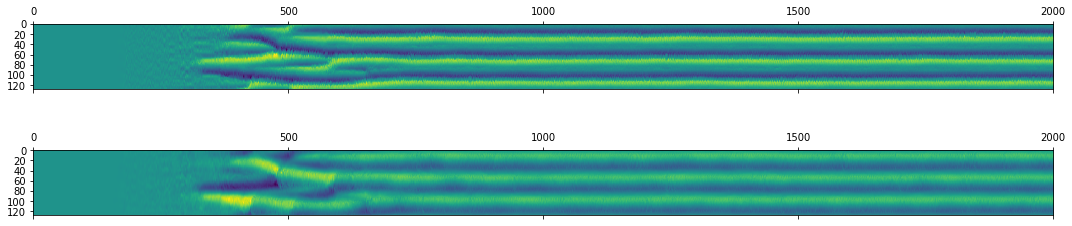

In [2]:
fig, ax = plt.subplots(2,figsize=(15,4))
ax[0].matshow(q_zonal_mean[:,:,0].T)
ax[1].matshow(q_zonal_mean[:,:,1].T)
plt.tight_layout()

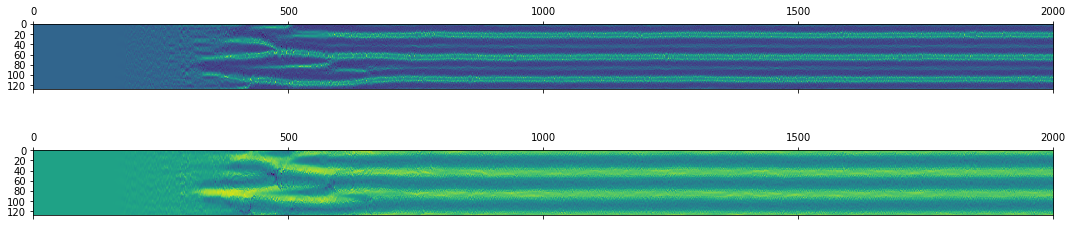

In [3]:
fig, ax = plt.subplots(2,figsize=(15,4))
ax[0].matshow(dq_zonal_mean[:,:,0].T)
ax[1].matshow(dq_zonal_mean[:,:,1].T)
plt.tight_layout()

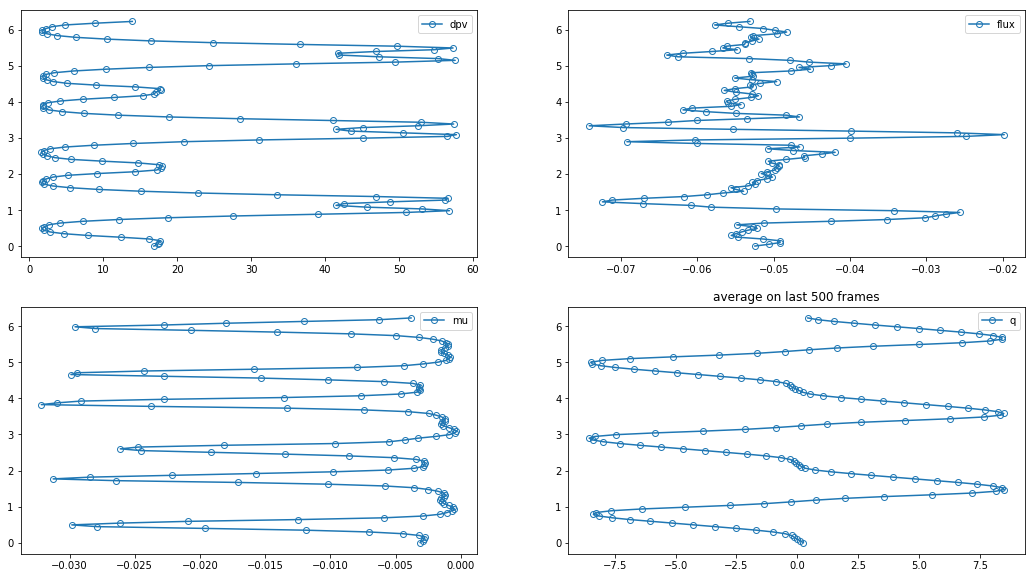

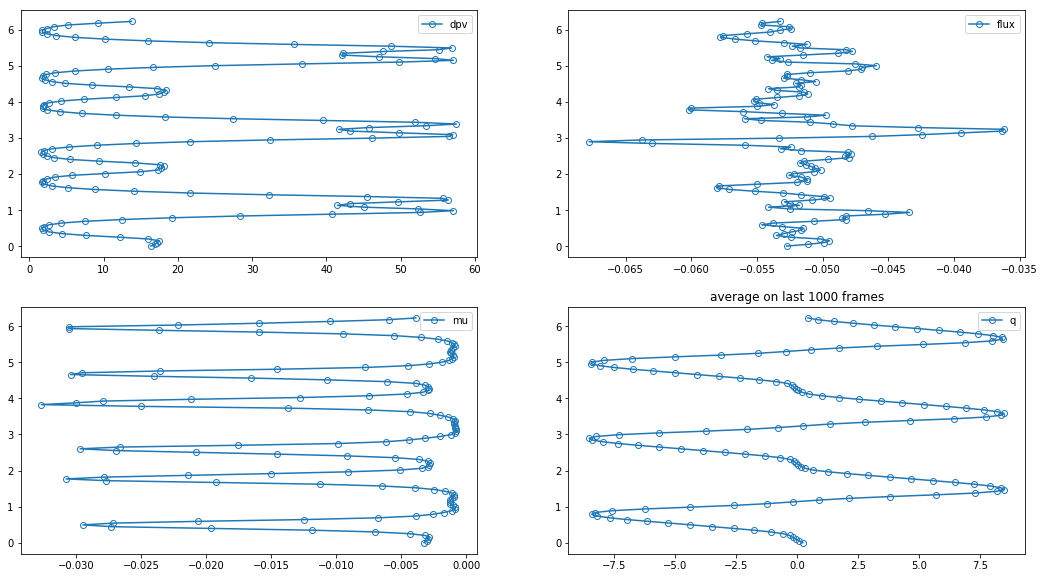

In [4]:
for i in [500,1000]:
    layer = 0
    t_mean_steps = range(-i,-1)
    flux_mean    = np.mean(flux_zonal_mean[t_mean_steps, :, :], axis = 0)
    dpv_mean     = np.mean(dpv_zonal_mean[t_mean_steps, :, :],  axis = 0)
    q_mean       = np.mean(q_zonal_mean[t_mean_steps, :, :],    axis = 0)

    
    mu_mean = flux_mean / dpv_mean
    fig, ax = plt.subplots(2,2,figsize=(18,10))
    ax[0,0].plot(dpv_mean[:, layer], yy, "-o", fillstyle = "none", label="dpv")
    ax[0,0].legend()
    ax[0,1].plot(flux_mean[:, layer], yy, "-o", fillstyle = "none", label="flux")
    ax[0,1].legend()
    ax[1,0].plot(mu_mean[:, layer], yy, "-o", fillstyle = "none", label="mu")
    ax[1,0].legend()
    ax[1,1].plot(q_mean[:, layer], yy, "-o", fillstyle = "none", label="q")
    ax[1,1].legend()
    plt.title("average on last %d frames" %i)

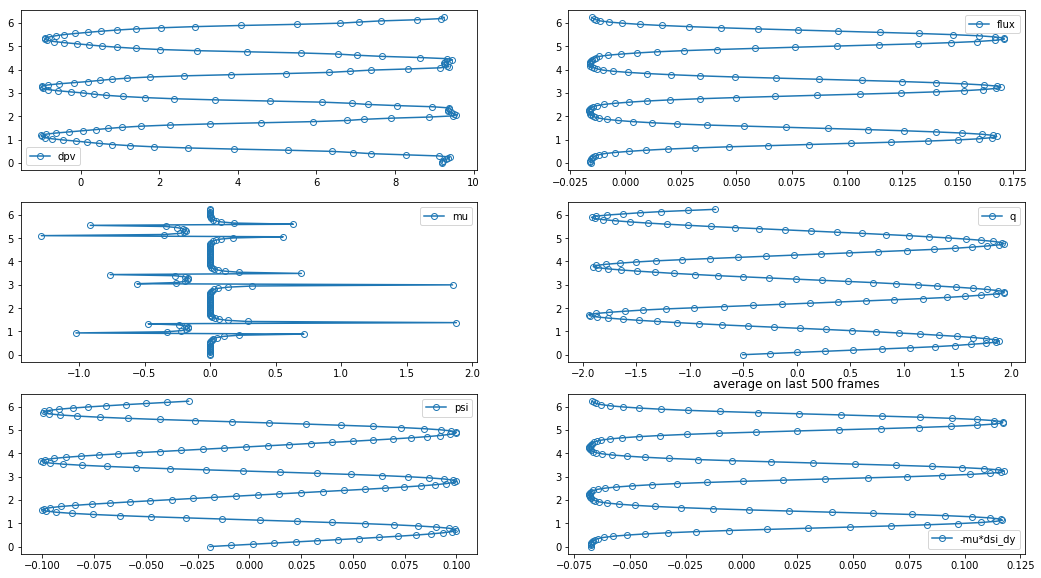

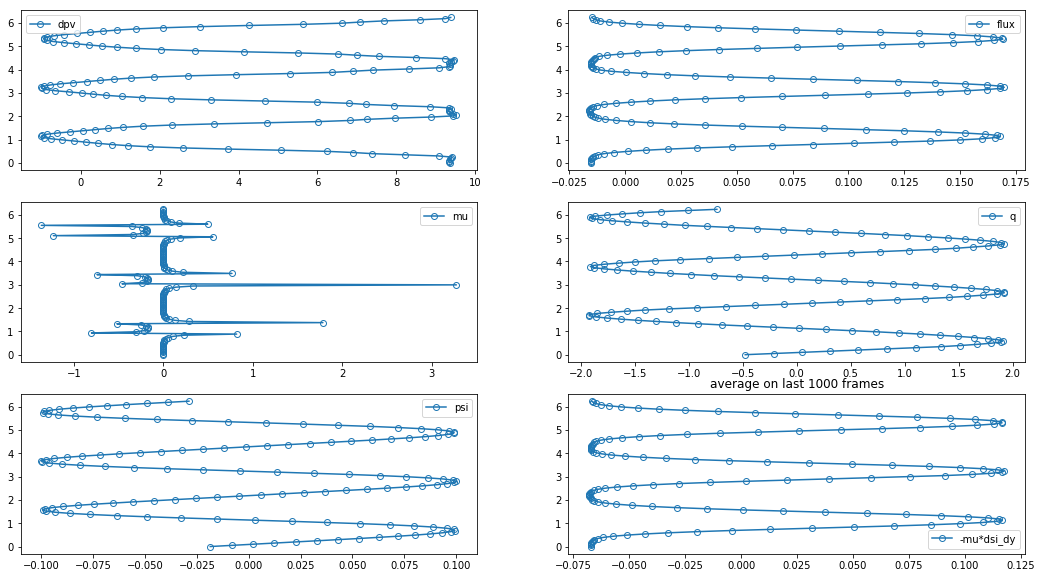

In [5]:
for i in [500,1000]:
    layer = 1
    t_mean_steps = range(-i,-1)
    flux_mean    = np.mean(flux_zonal_mean[t_mean_steps, :, :], axis = 0)
    dpv_mean     = np.mean(dpv_zonal_mean[t_mean_steps, :, :],  axis = 0)
    q_mean       = np.mean(q_zonal_mean[t_mean_steps, :, :],    axis = 0)
    psi_mean     = np.mean(psi_zonal_mean[t_mean_steps, :, :],    axis = 0)
    
    dpsi_mean_dy = np.copy(psi_mean)
    dpsi_mean_dy[:, 0] = gradient_first(psi_mean[:, 0], dy)
    dpsi_mean_dy[:, 1] = gradient_first(psi_mean[:, 1], dy)
    
    mu_mean = flux_mean / dpv_mean
    
    fig, ax = plt.subplots(3,2,figsize=(18,10))
    ax[0,0].plot(dpv_mean[:, layer], yy, "-o", fillstyle = "none", label="dpv")
    ax[0,0].legend()
    ax[0,1].plot(flux_mean[:, layer], yy,"-o", fillstyle = "none", label="flux")
    ax[0,1].legend()
    ax[1,0].plot(mu_mean[:, layer], yy,"-o", fillstyle = "none", label="mu")
    ax[1,0].legend()
    ax[1,1].plot(q_mean[:, layer], yy,"-o", fillstyle = "none", label="q")
    ax[1,1].legend()
    ax[2,0].plot(psi_mean[:, layer], yy, "-o", fillstyle = "none", label="psi")
    ax[2,0].legend()
    ax[2,1].plot(-mu*dpsi_mean_dy[:, layer], yy, "-o", fillstyle = "none", label="-mu*dsi_dy")
    ax[2,1].legend()
    plt.title("average on last %d frames" %i)

Text(0.5,1,'plug in mu')

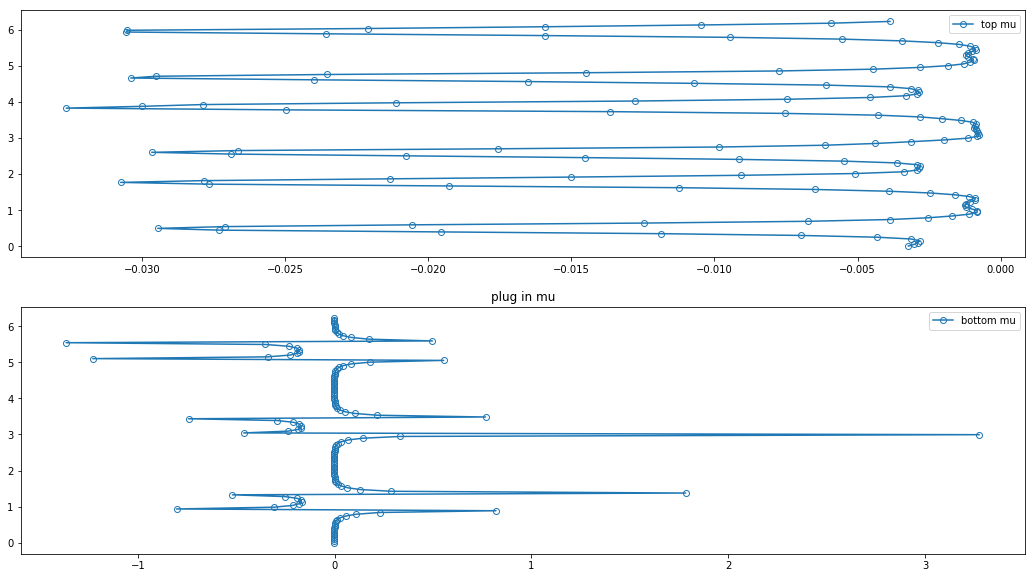

In [6]:
mu_mean = postprocess_mu(pre_file, L, beta1, beta2, last_n_outputs = 1000)

fig, ax = plt.subplots(2,figsize=(18,10))
ax[0].plot(mu_mean[0, :], yy, "-o", fillstyle = "none", label="top mu")
ax[0].legend()
ax[1].plot(mu_mean[1, :], yy, "-o", fillstyle = "none", label="bottom mu")
ax[1].legend()
plt.title("plug in mu")

In [7]:
from Solver_q import *


mu_mean_clip = np.copy(mu_mean)
mu_mean_clip[mu_mean_clip > 0] = 0.0

save_every = 1000
save_every = 1000
dt = 1e-3
Nt = 400000 #4000*10

y_sol, t_sol, q_sol = solve_q(Ny, L, f0, g, H, rho, beta, mu, dU, hyper_nu, hyper_order,
            dt, Nt, save_every,
            "nummodel", mu_mean_clip)

1000 max q 1.5125599848271996
2000 max q 2.1229753664249817
3000 max q 2.458781014998375
4000 max q 2.771890136938026
5000 max q 3.0164480009622445
6000 max q 3.2347745455909434
7000 max q 3.4194549882753114
8000 max q 3.58028314871927
9000 max q 3.72453747603151
10000 max q 3.856892977842948
11000 max q 3.980418460324847
12000 max q 4.097166476988907
13000 max q 4.2133928034989765
14000 max q 4.334873297807734
15000 max q 4.45057488065882
16000 max q 4.561357563548934
17000 max q 4.667867854499002
18000 max q 4.7705976738086315
19000 max q 4.869926130455351
20000 max q 4.966149417296787
21000 max q 5.059502378732979
22000 max q 5.150174181707983
23000 max q 5.238319772752977
24000 max q 5.324068299092208
25000 max q 5.40752932714482
26000 max q 5.489029662370039
27000 max q 5.570157006807181
28000 max q 5.649278542437296
29000 max q 5.726457613250527
30000 max q 5.801752812787074
31000 max q 5.875218871778351
32000 max q 5.946907332404632
33000 max q 6.016867062753715
34000 max q 6.08

In [ ]:
plt.figure()
plt.plot(np.mean(q_sol[Nt//(2*save_every):, 0, :], axis=0), y_sol,  label="top")
plt.plot(np.mean(q_sol[Nt//(2*save_every):, 1, :], axis=0), y_sol,  label="bottom")

plt.ylabel("y")
plt.legend()
plt.show()

Text(0.5,1,'average on last 1000 frames')

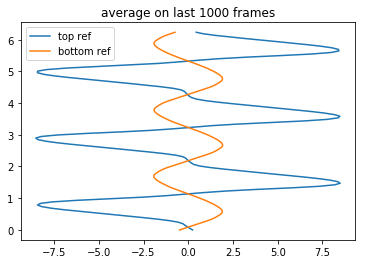

In [9]:
q_mean_ref = np.mean(q_zonal_mean[range(-1000,-1), :, :], axis = 0)
fig, ax = plt.subplots(1)
ax.plot(q_mean_ref[:, 0], yy, label="top ref")
ax.plot(q_mean_ref[:, 1], yy, label="bottom ref")
ax.legend()
plt.title("average on last 1000 frames")

In [ ]:
from Solver_q import *


mu_mean_clip = np.copy(mu_mean)
mu_mean_clip[1, :] = 0.00

save_every = 1000
save_every = 1000
dt = 1e-3
Nt = 400000 #4000*10
y_sol, t_sol, q_sol = solve_q(Ny, L, f0, g, H, rho, beta, mu, dU, hyper_nu, hyper_order,
            dt, Nt, save_every,
            "nummodel", mu_mean_clip)

1000 max q 1.5125599848271996
2000 max q 2.1229753664249817
3000 max q 2.458781014998375
4000 max q 2.771890136938026
5000 max q 3.0164480009622445
6000 max q 3.2347745455909434
7000 max q 3.4194549882753114
8000 max q 3.58028314871927
9000 max q 3.72453747603151
10000 max q 3.856892977842948
11000 max q 3.980418460324847
12000 max q 4.097166476988907
13000 max q 4.2133928034989765
14000 max q 4.334873297807734
15000 max q 4.45057488065882
16000 max q 4.561357563548934


In [ ]:
plt.figure()
plt.plot(np.mean(q_sol[Nt//(2*save_every):, 0, :], axis=0), y_sol,  label="top")
plt.plot(np.mean(q_sol[Nt//(2*save_every):, 1, :], axis=0), y_sol,  label="bottom")

plt.ylabel("y")
plt.legend()
plt.show()

In [13]:
mu_mean_clip.shape

(2, 128)

In [28]:
q.shape

(2001, 128, 128, 2)